In [46]:
import itertools
import json

import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

stopwords = set(nltk.corpus.stopwords.words('english'))
stem_func = nltk.PorterStemmer().stem

df = pd.read_csv('C:/Users/matth/Desktop/ADSProject1/data/philosophy_data.csv')
df['tokenized_txt_list'] = df['tokenized_txt'].apply(
    lambda x: [stem_func(word) for word in json.loads(x.replace("'", "\"")) if word not in stopwords])

df['century'] = (df['original_publication_date'] // 100) * 100
df.loc[df['century'] < 1600, 'century'] = -1000000
df.to_csv('../output/data_with_tokenized_txt.csv', index=False)

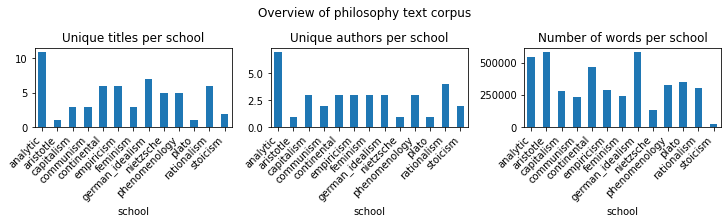

In [68]:
fig, ax = plt.subplots(nrows=1, ncols=3, constrained_layout=True, figsize=(10, 3))
plt.suptitle('Overview of philosophy text corpus')

group = 'school'
df.groupby(group)['title'].nunique().plot(kind='bar', title=f'Unique titles per {group}', ax=ax[0])
df.groupby(group)['author'].nunique().plot(kind='bar', title=f'Unique authors per {group}', ax=ax[1])

words_by_group = df.groupby(group)['tokenized_txt_list'].apply(lambda x: list(itertools.chain.from_iterable(x)))
words_by_group.apply(len).plot(kind='bar', title=f'Number of words per {group}', ax=ax[2])

for i in range(len(ax)):
#     ax[i].set_xticklabels(['pre-1600'] + list(ax[i].get_xticklabels()[1:]), rotation=45, ha='right')
    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=45, ha='right')

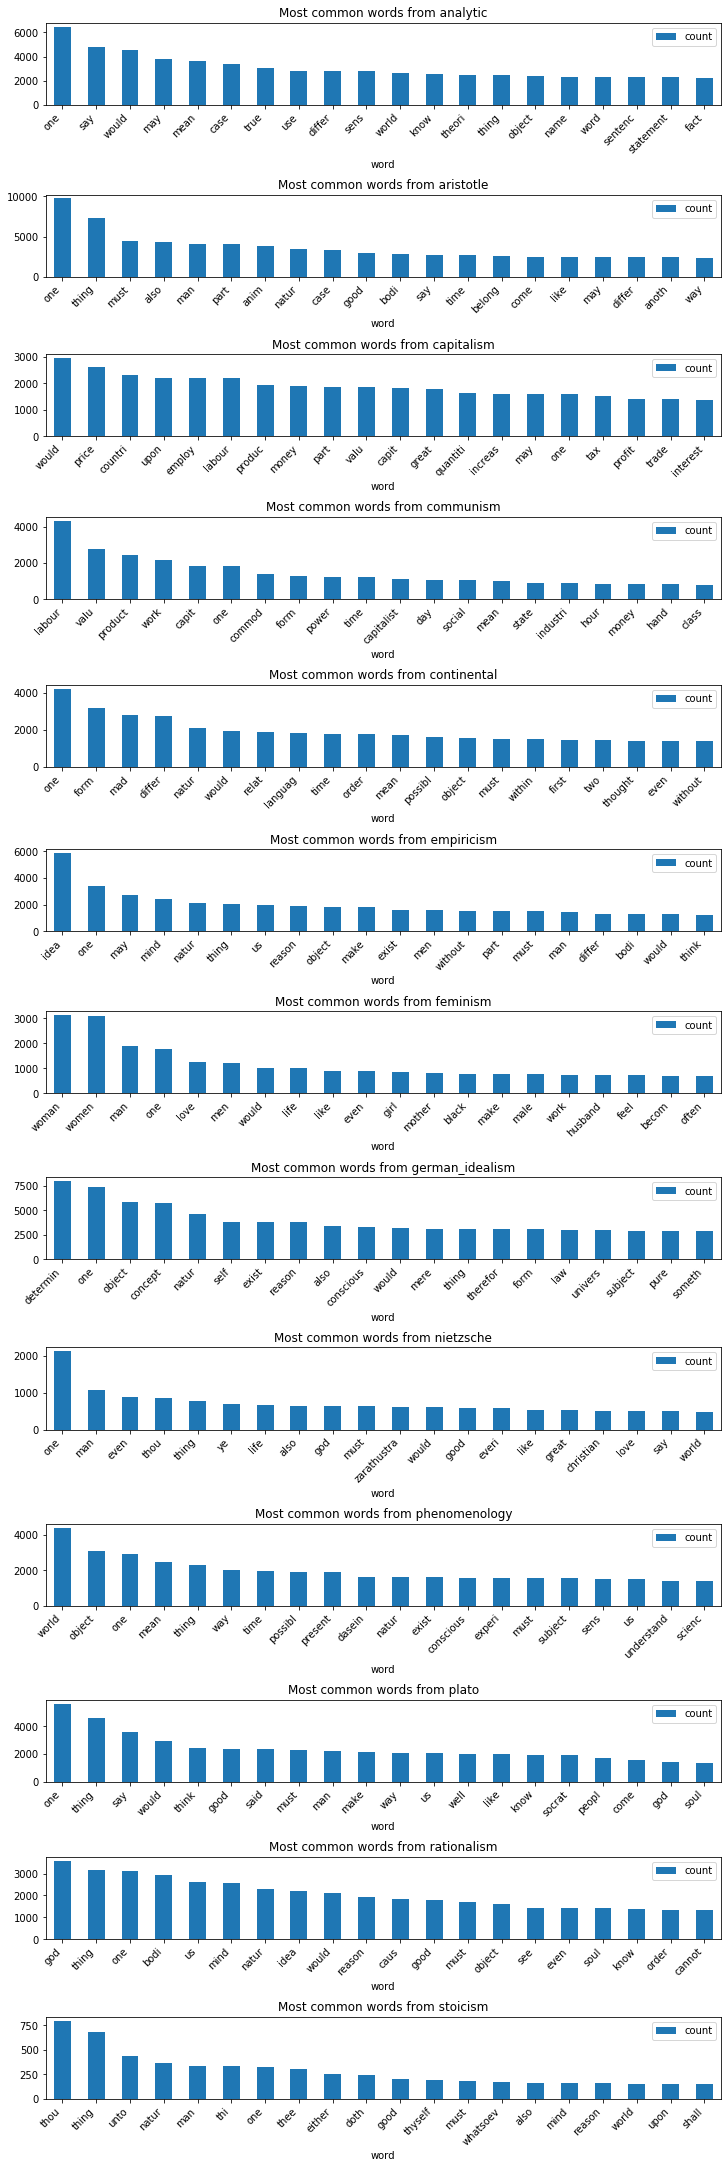

In [66]:
fig, ax = plt.subplots(nrows=words_by_group.shape[0], figsize=(10, 30), constrained_layout=True)

wcs = []
for i, (group_name, words) in enumerate(words_by_group.iteritems()):
    words, counts = np.unique(words, return_counts=True)
    wc = pd.DataFrame({'word': words, 'count': counts})
    wc = wc[~wc['word'].isin(stopwords)].sort_values('count', ascending=False)
#     century_label = 'pre-1600' if century < 1600 else str(century)
    wc.iloc[:20,].plot(x='word', y='count', kind='bar', title=f'Most common words from {group_name}', ax=ax[i])

for i in range(len(ax)):
    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=45, ha='right')

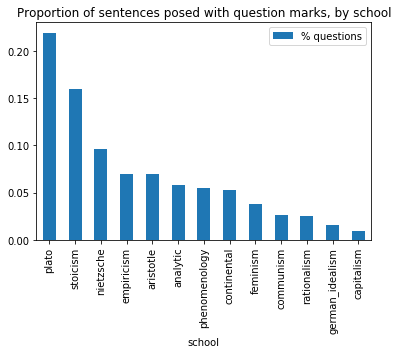

In [125]:
df['question'] = df['sentence_lowered'].str.contains('\?')
q_grouped = df.groupby([group, 'question'])['sentence_lowered'].count() / df.groupby(group)['sentence_lowered'].count()
q_proportions = q_grouped[q_grouped.index.get_level_values('question') == True] \
    .reset_index().drop('question', axis='columns').rename(columns={'sentence_lowered': '% questions'})
q_proportions.sort_values('% questions', ascending=False).plot(
    kind='bar', x=group, y='% questions', title=f'Proportion of sentences posed with question marks, by {group}')

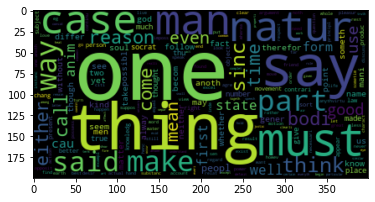

In [8]:
import wordcloud
cloud = wordcloud.WordCloud().generate(json.dumps(words_by_century.iloc[0]))
plt.imshow(cloud, interpolation='bilinear')